In [25]:
from pathlib import Path
import tflite
import tvm
from tvm import relay, transform
from tvm import te
import matplotlib.pyplot as plt
import imageio
import cv2
import numpy as np
from typing import NamedTuple
from PIL import Image
from matplotlib.patches import Rectangle
import logging
logging.basicConfig(level=logging.INFO)

In [16]:
tvm.__version__

'0.8.dev0'

In [17]:
model_path = Path.cwd().parent / 'models' / 'blazeface' / 'face_detection_short_range.tflite'
model_path.exists()

True

In [18]:
with open(model_path, 'rb') as f:
    tflite_model_buf = f.read()
    tflite_model = tflite.Model.GetRootAsModel(tflite_model_buf, 0)
    input_tensor = "input"
    input_shape  = (1, 128, 128, 3)
    input_dtype  = "float32"
    
    mod, params = relay.frontend.from_tflite(
        tflite_model, 
        shape_dict = {input_tensor: input_shape},
        dtype_dict = {input_tensor: input_dtype}
    )
    target = "llvm"
    
    desired_layouts = {'nn.conv2d': ['NCHW', 'default']}

    # Convert the layout to NCHW
    seq = tvm.transform.Sequential([relay.transform.RemoveUnusedFunctions(),
                                    relay.transform.ConvertLayout(desired_layouts)])
    
    with transform.PassContext(opt_level=3):
        mod = seq(mod)
        lib=relay.build(mod, target, params=params)

DEBUG:autotvm:Finish loading 35 records
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using transpose.generic for transpose based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for reshape based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engin

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using transpose.generic for transpose based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for reshape based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_di

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for reshape based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_dims based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using transpose.generic for transpose based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for cast based on highest priority (10)
INFO:compile_engine:Using injective.cpu for expand_di

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest pr

INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using conv2d_NCHWc.x86 for nn.contrib_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using injective.cpu for nn.pad based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using injective.cpu for nn.relu based on highest priority (10)
INFO:compile_engine:Using pool.cpu for nn.max_pool2d based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using depthwise_conv2d_NCHWc.x86 for nn.contrib_depthwise_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using c

INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using conv2d_NCHWc.x86 for nn.contrib_conv2d_NCHWc based on highest priority (10)
INFO:compile_engine:Using injective.cpu for add based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for reshape based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for layout_transform based on highest priority (10)
INFO:compile_engine:Using injective.cpu for reshape based on highest priority (10)
INFO:compile_engine:Using concatenate.cpu for concatenate based on highest priority (10)


In [11]:
video_path = Path.cwd().parent / "assets" / "head-pose-face-detection-male.mp4"
video_path.exists()

True

In [12]:
reader = imageio.get_reader(str(video_path))

In [ ]:
cv2.make

In [72]:
image_data = None

def resize_img(img):
    pil_img = Image.fromarray(img)
    pil_img = pil_img.resize((128, 128), Image.BILINEAR)    
    return np.asarray(pil_img)

for frame in reader:
    imageio.imwrite("face_detect.bmp", frame)
    r, c, _ = frame.shape
    padx, pady = ((r-c)//2, 0) if r > c else (0, (c - r)//2)
    frame = cv2.copyMakeBorder(frame, pady, pady, padx, padx, cv2.BORDER_CONSTANT, None, 0)
    image_data = resize_img(frame)
    image_data = image_data * 1.0 / 127.5
    image_data += (-1.0)
    image_data = image_data.astype(np.float32)
    break
image_data.shape, image_data.dtype

((128, 128, 3), dtype('float32'))

In [73]:
frame.shape

(768, 768, 3)

In [74]:
image_data = image_data[np.newaxis, :]
image_data.shape

(1, 128, 128, 3)

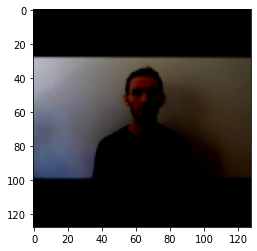

In [75]:
_, ax = plt.subplots(1)
ax.imshow(np.squeeze(image_data))
plt.show()

In [76]:
import tvm
from tvm import te
from tvm.contrib import graph_executor as runtime

# Create a runtime executor module
module = runtime.GraphModule(lib["default"](tvm.cpu()))

# Feed input data
module.set_input(input_tensor, tvm.nd.array(image_data))

# Run
module.run()

In [77]:
output_1 = module.get_output(0).numpy()
output_2 = module.get_output(1).numpy()

In [78]:
output_1.shape

(1, 896, 16)

In [79]:
output_2.shape

(1, 896, 1)

In [80]:
np.min(np.squeeze(output_2))

-308.47504

In [81]:
scores = np.squeeze(output_2)

RAW_SCORE_LIMIT = 80
scores[scores < -RAW_SCORE_LIMIT] = -RAW_SCORE_LIMIT
scores[scores > RAW_SCORE_LIMIT] = RAW_SCORE_LIMIT
    
scores = 1 / (1 + np.exp(-scores))
max_score_index = np.argmax(scores)
max_score = scores[max_score_index]
max_score, max_score_index

(0.94741106, 241)

In [82]:
SSD_OPTIONS_FRONT = {
    'num_layers': 4,
    'input_size_height': 128,
    'input_size_width': 128,
    'anchor_offset_x': 0.5,
    'anchor_offset_y': 0.5,
    'strides': [8, 16, 16, 16],
}

def get_anchor_boxes(opts: dict):
    layer_id = 0
    num_layers = opts['num_layers']
    strides = opts['strides']
    assert len(strides) == num_layers
    input_height = opts['input_size_height']
    input_width = opts['input_size_width']
    anchor_offset_x = opts['anchor_offset_x']
    anchor_offset_y = opts['anchor_offset_y']
    anchors = []
    while layer_id < num_layers:
        last_same_stride_layer = layer_id
        repeats = 0
        while (last_same_stride_layer < num_layers and
               strides[last_same_stride_layer] == strides[layer_id]):
            last_same_stride_layer += 1
            repeats += 2    # aspect_ratios are added twice per iteration
        stride = strides[layer_id]
        feature_map_height = input_height // stride
        feature_map_width = input_width // stride
        for y in range(feature_map_height):
            y_center = (y + anchor_offset_y) / feature_map_height
            for x in range(feature_map_width):
                x_center = (x + anchor_offset_x) / feature_map_width
                for _ in range(repeats):
                    anchors.append((x_center, y_center))
        layer_id = last_same_stride_layer
    return np.array(anchors, dtype=np.float32)


In [83]:
def decode_boxes(raw_boxes: np.ndarray, anchors) -> np.ndarray:
    """Simplified version of
    mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
    """
    scale = 128
    num_points = raw_boxes.shape[-1] // 2
    
    # scale all values (applies to positions, width, and height alike)
    boxes = raw_boxes.reshape(-1, num_points, 2) / scale
    # adjust center coordinates and key points to anchor positions
    boxes[:, 0] += anchors
    
    for i in range(2, num_points):
        boxes[:, i] += anchors
    # convert x_center, y_center, w, h to xmin, ymin, xmax, ymax
    center = np.array(boxes[:, 0])
    half_size = boxes[:, 1] / 2
    boxes[:, 0] = center - half_size
    boxes[:, 1] = center + half_size
    return boxes

In [84]:
anchors = get_anchor_boxes(SSD_OPTIONS_FRONT)
raw_boxes = np.squeeze(output_1)
boxes = decode_boxes(raw_boxes, anchors)
boxes.shape

(896, 8, 2)

In [85]:
MIN_SCORE = 0.5
score_above_threshold = scores > MIN_SCORE
idx = np.argwhere(score_above_threshold)
filtered_scores = scores[score_above_threshold]
filtered_boxes =  boxes[idx[:, 0], :]
filtered_boxes.dtype

dtype('float32')

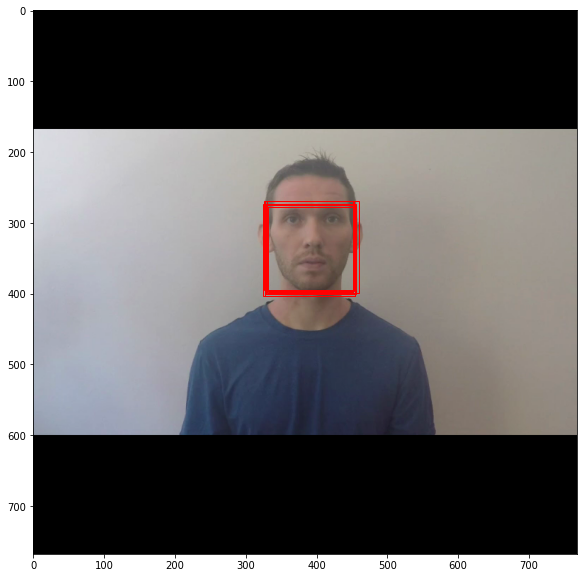

In [87]:
plt.figure(figsize=(10,10))
plt.imshow(frame)
dr, dc, _ = frame.shape
for bb in filtered_boxes:
    x1 = int(bb[0][0] * dc)
    y1 = int(bb[0][1] * dr)

    x2 = int(bb[1][0] * dc)
    y2 = int(bb[1][1] * dr)

    w = int(abs(x1 - x2))
    h = int(abs(y1 - y2))
    plt.gca().add_patch(Rectangle((x1,y1), w, h,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
plt.show()

In [134]:
from typing import NamedTuple

class Box(NamedTuple):
    xmin : float
    xmax : float
    ymin : float
    ymax : float
    
def _area(box):    
    width = box.xmax - box.xmin
    height = box.ymax - box.ymin
    return width * height
        
class Detection(NamedTuple):
    score: float
    bbox: Box
        
def make_detection(score, keypoints):
    xmin, ymin = keypoints[0]
    xmax, ymax = keypoints[1]
    bbox = Box(xmin, xmax, ymin, ymax)
    
    return Detection(score, bbox)

def _overlap_similarity(box1, box2):
    intersection = _intersection(box1, box2)
    if intersection is None:
        return 0.
    intersect_area = _area(intersection)
    denominator = _area(box1) + _area(box2) - intersect_area
    return intersect_area / denominator if denominator > 0. else 0.

def _intersection(box1, box2):
    xmin, ymin = max(box1.xmin, box2.xmin), max(box1.ymin, box2.ymin)
    xmax, ymax = min(box1.xmax, box2.xmax), min(box1.ymax, box2.ymax)
    if xmin < xmax and ymin < ymax:
        return Box(xmin, ymin, xmax, ymax)
    else:
        return None

def _weighted_non_maximum_suppression(indexed_scores,detections,min_suppression_threshold,min_score):
    remaining_indexed_scores = list(indexed_scores)
    remaining  = []
    candidates = []
    outputs    = []

    while len(remaining_indexed_scores):
        detection = detections[remaining_indexed_scores[0][0]]
        # exit loop if remaining scores are below threshold
        if detection.score < min_score:
            break
        num_prev_indexed_scores = len(remaining_indexed_scores)
        detection_bbox = detection.bbox
        remaining.clear()
        candidates.clear()
        weighted_detection = detection
        for (index, score) in remaining_indexed_scores:
            remaining_bbox = detections[index].bbox
            similarity = _overlap_similarity(remaining_bbox, detection_bbox)
            if similarity > min_suppression_threshold:
                candidates.append((index, score))
            else:
                remaining.append((index, score))
        # weighted merging of similar (close) boxes
        if len(candidates):
            weighted = np.zeros((2 + len(detection), 2), dtype=np.float32)
            total_score = 0.
            for index, score in candidates:
                total_score += score
                weighted += detections[index].data * score
            weighted /= total_score
            weighted_detection = Detection(weighted, detection.score)
        outputs.append(weighted_detection)
        # exit the loop if the number of indexed scores didn't change
        if num_prev_indexed_scores == len(remaining):
            break
        remaining_indexed_scores = list(remaining)
    return outputs
    
def nms(boxes, scores):
    indexed_scores = [(n, score) for n, score in enumerate(scores)]
    indexed_scores = sorted(indexed_scores, key=lambda p: p[1], reverse=True)
    detections = [make_detection(s,b) for s, b in zip(filtered_scores, filtered_boxes)]
    return _weighted_non_maximum_suppression(
            indexed_scores, detections, 0.3, 0.5)

In [155]:
output = nms(filtered_boxes, filtered_scores)

dr, dc, _ = frame.shape
print(output)

output = [Box(int(b.xmin * dc), 
              int(b.xmax * dc),
              int(b.ymin * dr),              
              int(b.ymax * dr)) for _,b in output]
print(output)

[Detection(score=0.94741106, bbox=Box(xmin=0.42383996, xmax=0.59335023, ymin=0.35550505, ymax=0.5250145))]
[Box(xmin=325, xmax=455, ymin=273, ymax=403)]


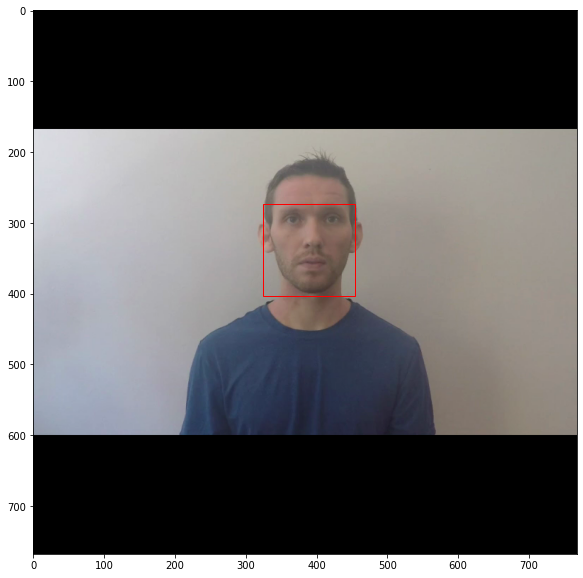

In [156]:
plt.figure(figsize=(10,10))
plt.imshow(frame)
dr, dc, _ = frame.shape
for box in output:
    x1 = box.xmin
    y1 = box.ymin

    x2 = box.xmax
    y2 = box.ymax

    w = int(abs(x1 - x2))
    h = int(abs(y1 - y2))
    plt.gca().add_patch(Rectangle((x1,y1), w, h,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
plt.show()

In [138]:
padx, pady

(0, 168)

In [160]:
def remove_letter_box(boxes, padx, pady):
    print(box)
    return [Box(box.xmin - padx,
                box.xmax - padx,
                box.ymin - pady,
                box.ymax - pady) for box in boxes]

Box(xmin=325, xmax=455, ymin=105, ymax=235)


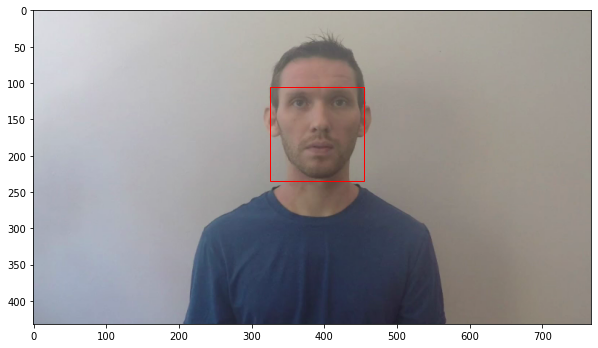

In [164]:
output1 = remove_letter_box(output, padx, pady)
plt.figure(figsize=(10,10))
plt.imshow(frame[pady:frame.shape[0]-pady,padx:frame.shape[1]-padx])
dr, dc, _ = frame.shape
for box in output1:
    x1 = box.xmin
    y1 = box.ymin

    x2 = box.xmax
    y2 = box.ymax

    w = int(abs(x1 - x2))
    h = int(abs(y1 - y2))
    plt.gca().add_patch(Rectangle((x1,y1), w, h,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
plt.show()